<a href="https://colab.research.google.com/github/nyluje/RCP217_DILATE/blob/main/RCP217_Projet_2023_DILATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet RCP217: *Dynamic Time Wrapping* et prédiction structurée

## Import des librairies utilisées

Au moment de la réalisation du projet l'environnement par défaut du service Google Colab utilisait les versions suivantes des librairies:

* `numpy version 1.21.6` ;
* `matplotlib version 3.2.2` ;
* `torch version 1.13.0+cu116` ;
* `python version 3.8.16` ;
* `tslearn version 0.5.2`.


In [ ]:
#import des librairies utilisées

import numpy as np
import matplotlib
import matplotlib.pyplot as plt


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

%pip install tslearn
import tslearn
from tslearn.metrics import dtw, dtw_path

import os
import random
import sys
import warnings
import warnings; warnings.simplefilter('ignore')

print(f'numpy version {np.__version__}')
print(f'matplotlib version {matplotlib.__version__}')
print(f'torch version {torch.__version__}')
print(f'python version {sys.version}')
print(f'tslearn version {tslearn.__version__}')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.8/875.8 KB 9.1 MB/s eta 0:00:00
numpy version 1.21.6
matplotlib version 3.2.2
torch version 1.13.0+cu116
python version 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
tslearn version 0.5.2


## Implémentation de DILATE

### Récupération des classes réalisées dans le cadre du projet DILATE par Le Guen et al. (2019).

Les fonctions permettant de calculer l'erreur (le niveau de déformation) entre un chemin prédit et un chemin attendu sur la forme et le temps, sont récupérées sur le service Github.

Les fichiers du répertoire `loss` sont concatenés dans le seul fichier `loss/dilate_loss.py` pour contourner des erreurs de dépendances de package si utlisés tels quels.

In [ ]:
%cd /content
!rm -r ./loss
!rm -r ./data
!rm -r ./DILATE

!git clone https://github.com/vincent-leguen/DILATE

!cp -r ./DILATE/loss ./
!cp -r ./DILATE/data ./
!rm -r ./DILATE

#Les fichiers sont concatenés dans un seul, et le contenu légérement arrangé en consséquence.
#C'est une solution de contournement pour éviter une erreur de package inconnu lors de l'import des fonctions.
!echo " " >> ./loss/dilate_loss.py
!cat ./loss/soft_dtw.py >> ./loss/dilate_loss.py
!echo " " >> ./loss/dilate_loss.py
!cat ./loss/path_soft_dtw.py >> ./loss/dilate_loss.py
!rm  ./loss/soft_dtw.py
!rm  ./loss/path_soft_dtw.py
!sed -i '2,3 s/^/#/' ./loss/dilate_loss.py
!sed -i '9 s/soft_dtw.//g' ./loss/dilate_loss.py
!sed -i '12 s/soft_dtw.//g' ./loss/dilate_loss.py
!sed -i '18 s/soft_dtw.//g' ./loss/dilate_loss.py
!sed -i '16 s/path_soft_dtw.//g' ./loss/dilate_loss.py

/content
rm: cannot remove './loss': No such file or directory
rm: cannot remove './data': No such file or directory
rm: cannot remove './DILATE': No such file or directory
Cloning into 'DILATE'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 69 (delta 6), reused 2 (delta 0), pack-reused 52
Unpacking objects: 100% (69/69), done.


### Ajout dans l'environnement des classes des fichiers importées

Afin d'utiliser les classes dans les fichiers Python importés, les chemins où sont localisés ces fichiers sont ajoutés aux chemins du système.

In [ ]:
for i in ['/content/data','/content/loss']:
  directory_path = os.path.abspath(os.path.join(i))
  if directory_path not in sys.path:
      sys.path.append(directory_path)

In [ ]:
#from tslearn.metrics.softdtw_variants import soft_dtw
from synthetic_dataset import create_synthetic_dataset, SyntheticDataset
from dilate_loss import *

Les fonctions importées sont les suivantes:
- La fonction de perte `dilate_loss()`:
 - Elle prend en paramètres: 
   - Les sorties générées par le modèle ; 
   - Les sorties attendues ; 
   - Le paramètre $\alpha$ permet de balancer la pondération entre la perte de la forme et la perte temporelle dans le resultat de la fonction de perte ;
   - Le paramètre $\gamma$ est utlisé dans l'opérateur minimum régularisé (approximation lisse de la fonction minimum) ;
   - Le parmètre *device* correspond au type de processeur utilisé pour le cacul ;
 - Et renvoie: 
   - La fonction de perte `loss` ;
   - La fonction de perte de la forme `loss_shape` ;
   - La fonction de perte temporelle `loss_temporal`.

- La fonction `create_synthetic_dataset`, qui crée un ensemble des séries temporelles avec des variation brusques :
 - Prend en paramètres:     
   - Le nombre de séries temporelles dans chaque jeux de données ;
   - Le nombre d'unités de temps initiant une serie temporelle ;
   - Le nombre d'unités de temps pour lesquels une prédiction est attendue ;
   - L'écart type pour rajouter du bruit ;
 - Et renvoie: 
   - Les échantillons de données d'apprentissage contenant les entrées des séries temporelles ;
   - Les échantillon de données d'apprentissage contenant les prédictions attendues des séries temporelles ;
   - Les échantillon de données de test contenant les entrées des séries temporelles ;
   - Les échantillon de données de test contenant les prédictions attendues des série temporelles ;
   - Les points de séparation pour les échantillons des données d'apprentissage (non utilisé) ;
   - Les points de séparation pour les échantillons des données de test (non utilisé).




### Jeu de données, héritage de la classe `Dataset`

Une classe `MonDataset`, héritant de la classe abstraite [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) pour gérer le jeu données est écrite. C'est une version simplifiée de la classe `SyntheticDataset` présente dans le fichier importé `synthetic_dataset.py`. Les notions de *breakpoints* y sont retirées. 

In [ ]:
class MonDataset(torch.utils.data.Dataset):
    def __init__(self, X_entrees, X_a_predire):
        super(MonDataset, self).__init__()  
        self.X_entrees = X_entrees
        self.X_a_predire = X_a_predire
        
    def __len__(self):
        return (self.X_entrees).shape[0]

    def __getitem__(self, index):
        return (self.X_entrees[index,:,np.newaxis], self.X_a_predire[index,:,np.newaxis]  )


### Création du réseau auto-encodeur Seq2Seq

L'architecture reprend une architecture Encodeur-Décodeur constitué de deux reséaux récurents de type Long Short-Term Memory (LSTM) -Utlisant le variant Gated Recurrent Unit (GRU). Le LSTM amméliore la mémoire des éléments précédents dans la série et évite un déséquilibre où les poids d'un RNN favoriseraient les derniers éléments de la série d'apprentissage.

**NB:** Le code ci-dessous est une reproduction du travail de Le Guen et al. (2019). Les variables utilisées ont été traduites en français dans un style très verbeux afin d'illustrer la bonne compréhension des mécanismes par l'auditeur.



In [ ]:
class Encodeur(nn.Module):
  def __init__(self,taille_en_entree,taille_etat_cache,nombre_couches_lstm,taille_batch):
    super(Encodeur,self).__init__()
    self.taille_etat_cache= taille_etat_cache
    self.taille_batch=taille_batch
    self.nombre_couches_lstm= nombre_couches_lstm
    self.reseau_recurent_LSTM_type_GRU = nn.GRU(input_size= taille_en_entree,
            hidden_size=taille_etat_cache,
            num_layers=nombre_couches_lstm,
            batch_first=True
    )
  def forward(self,taille_en_entree,taille_etat_cache):
    sortie, couche_cachee = self.reseau_recurent_LSTM_type_GRU(taille_en_entree,taille_etat_cache)
    return sortie, couche_cachee
  def initialise_etat_cache(self,processeur):
    #Tenseur initialisant l'etat caché avec des 0
    return torch.zeros(self.nombre_couches_lstm, self.taille_batch, self.taille_etat_cache, device=processeur)


class Decodeur(nn.Module):
  def __init__(self, taille_en_entree, taille_etat_cache, nombre_couches_lstm, taille_couche_completement_connecte, taille_sortie):
    super(Decodeur,self).__init__()
    self.reseau_recurent_LSTM_type_GRU=nn.GRU(input_size=taille_en_entree,hidden_size=taille_etat_cache,num_layers=nombre_couches_lstm, batch_first=True)
    self.couche_completement_connectee=nn.Linear(taille_etat_cache, taille_couche_completement_connecte)
    self.sortie= nn.Linear(taille_couche_completement_connecte,taille_sortie)

  def forward(self,taille_en_entree, taille_etat_cache):
    sortie, etat_cache = self.reseau_recurent_LSTM_type_GRU(taille_en_entree,taille_etat_cache)
    sortie = F.relu(self.couche_completement_connectee(sortie))
    sortie = self.sortie(sortie)
    return sortie, etat_cache

class EncodeurDecodeur(nn.Module):
  def __init__(self,encodeur,decodeur,taille_cible, processeur):
    super(EncodeurDecodeur, self).__init__()
    self.encodeur=encodeur
    self.decodeur=decodeur
    self.taille_cible=taille_cible
    self.processeur=processeur

  def forward(self,x):
    taille_entree=x.shape[1]
    encodeur_etat_cache = self.encodeur.initialise_etat_cache(self.processeur)
    for encodeur_i in range(taille_entree):
      encodeur_sortie, encodeur_etat_cache= self.encodeur(x[:,encodeur_i:encodeur_i+1,:], encodeur_etat_cache)

    decodeur_entree= x[:,-1,:].unsqueeze(1) #le premier element dans le decodeur correspond au dernier element de la séquence d entree
    decodeur_etat_cache = encodeur_etat_cache

    sorties= torch.zeros([x.shape[0], self.taille_cible, x.shape[2]]).to(self.processeur)
    for decodeur_i in range(self.taille_cible):
      decodeur_sortie, sortie_etat_cache = self.decodeur(decodeur_entree, decodeur_etat_cache)
      decodeur_entree =decodeur_sortie
      sorties[:,decodeur_i:decodeur_i+1,:]=decodeur_sortie
    return sorties


### Fonctions d'entrainement et évaluation

Le modèle d'entrainement est défini ainsi qu'une fonction d'évaluation du modèle :
- Le modèle d'entrainement utilise la fonction de perte DILATE de Le Guen et al. (2019) ;
- L'evaluation du modèle renvoie une moyenne du score de similarité de la fonction DTW de la libraire [tslearn](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw.html).

In [ ]:


def entrainement_du_modele(
    modele,
    pas_d_apprentissage,
    donnees_d_entrainement,
    epochs=1000,gamma_dilate=0.001,afficher_tous_les=50, evaluer_tous_les=50, verbose=1, alpha_dilate=0.5):
  
  optimiseur= torch.optim.Adam(modele.parameters(),lr=pas_d_apprentissage)

  for epoch in range(epochs):
    for entrees, sorties_attendues in donnees_d_entrainement:
      entrees= torch.tensor(entrees, dtype=torch.float32).to(processeur)
      sorties_attendues= torch.tensor(sorties_attendues, dtype=torch.float32).to(processeur)
      taille_batch, quantite_predite=sorties_attendues.shape[0:2]

      sorties=modele(entrees)
      perte, perte_forme, perte_temporelle = dilate_loss(sorties_attendues, sorties, alpha_dilate, gamma_dilate, processeur)

      optimiseur.zero_grad()
      perte.backward()
      optimiseur.step()

    if(verbose):
      if(epoch % afficher_tous_les==0):
          print('epoch: ', epoch ,' | perte: ', perte.item(), ' | perte forme: ', perte_forme.item(), ' | perte temporelle: ',perte_temporelle.item())

def evaluation_du_modele(modele, donnees_a_evaluer, verbose=1):
  pertes_dtw=[]

  for entrees, sorties_attendues in donnees_a_evaluer:
      entrees= torch.tensor(entrees, dtype=torch.float32).to(processeur)
      sorties_attendues= torch.tensor(sorties_attendues, dtype=torch.float32).to(processeur)
      taille_batch =sorties_attendues.shape[0]
      perte_dtw=0

      sorties= modele(entrees)

      for k in range(taille_batch):
        sorties_attendues_k_cpu=sorties_attendues[k,:,0:1].view(-1).detach().cpu().numpy()
        sorties_k_cpu = sorties[k,:,0:1].view(-1).detach().cpu().numpy()
        _, score_de_similarite= dtw_path(sorties_attendues_k_cpu,sorties_k_cpu)
        perte_dtw+=score_de_similarite

      perte_dtw/=taille_batch
      pertes_dtw.append(perte_dtw)

  return np.array(pertes_dtw).mean()






### Execution de l'apprentissage

Un apprentissage est effectué sur un jeu de données synthétique.

L'evaluation du modèle sur le jeu d'entraînement et le jeu de test sont affichés avant et après l'apprentissage de celui-ci.

Il est attendu que le résultat de l'évaluation -La moyenne du score de similarité entre prédiction et *ground truth* sur l'ensemble des séries temporelles- soit le plus bas possible. En effet: le score de similarité repose sur la distance euclidienne entre les points prédits et la *ground truth* mesurés. L'enjeu est de minimiser cette distance.



In [ ]:

processeur = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(451)

taille_batch = 100
nombre_echantillons = 500
longueur_partie_apprentissage_serie_temporelle = 20
longueur_partie_a_predire_serie_temporelle = 20
ecart_type = 0.01
gamma_dilate = 0.01



X_apprentissage_entree,X_apprentissage_a_predire,X_test_entree,X_test_a_predire,_,_ = create_synthetic_dataset(
    nombre_echantillons,
    longueur_partie_apprentissage_serie_temporelle,
    longueur_partie_a_predire_serie_temporelle,
    ecart_type)

dataset_apprentissage = MonDataset(X_apprentissage_entree,X_apprentissage_a_predire)
dataset_test  = MonDataset(X_test_entree,X_test_a_predire)
chargement_apprentissage = DataLoader(dataset_apprentissage, batch_size=taille_batch,shuffle=True, num_workers=1)
chargement_test  = DataLoader(dataset_test, batch_size=taille_batch,shuffle=False, num_workers=1)

encodeur = Encodeur(taille_en_entree=1,taille_etat_cache=128,nombre_couches_lstm=1,taille_batch=taille_batch).to(processeur)
decodeur = Decodeur(taille_en_entree=1, taille_etat_cache=128, nombre_couches_lstm=1, taille_couche_completement_connecte=16, taille_sortie=1).to(processeur)
encodeur_decodeur= EncodeurDecodeur(encodeur=encodeur,decodeur=decodeur,taille_cible=longueur_partie_a_predire_serie_temporelle, processeur=processeur)

print("DTW sur le jeu de données d'apprentissage avant entrainement " ,evaluation_du_modele(encodeur_decodeur, chargement_apprentissage, gamma_dilate))
print("DTW sur le jeu de données de test avant entrainement " ,evaluation_du_modele(encodeur_decodeur, chargement_test, gamma_dilate))


entrainement_du_modele(
    modele=encodeur_decodeur,
    pas_d_apprentissage=0.001,
    donnees_d_entrainement=chargement_apprentissage,
    epochs=500,gamma_dilate=gamma_dilate)


print("DTW sur le jeu de données d'apprentissage après entrainement " ,evaluation_du_modele(encodeur_decodeur, chargement_apprentissage, gamma_dilate))
print("DTW sur le jeu de données de test après entrainement " ,evaluation_du_modele(encodeur_decodeur, chargement_test, gamma_dilate))


DTW sur le jeu de données d'apprentissage avant entrainement  1.4098830167063197
DTW sur le jeu de données de test avant entrainement  1.3955731761158883
epoch:  0  | perte:  1.7209141254425049  | perte forme:  3.1131396293640137  | perte temporelle:  0.32868874073028564
epoch:  50  | perte:  0.543133020401001  | perte forme:  0.7708980441093445  | perte temporelle:  0.3153679370880127
epoch:  100  | perte:  0.3760656714439392  | perte forme:  0.4769482910633087  | perte temporelle:  0.2751830518245697
epoch:  150  | perte:  0.33545801043510437  | perte forme:  0.44488486647605896  | perte temporelle:  0.22603115439414978
epoch:  200  | perte:  0.2827785909175873  | perte forme:  0.28631457686424255  | perte temporelle:  0.279242604970932
epoch:  250  | perte:  0.23499716818332672  | perte forme:  0.19764575362205505  | perte temporelle:  0.2723485827445984
epoch:  300  | perte:  0.19190630316734314  | perte forme:  0.0671720951795578  | perte temporelle:  0.3166405260562897
epoch:  35

## Visualisation

Les courbes des prédictions et des résultats attendus, pour les 10 premières séries temporelles, sont affichées.

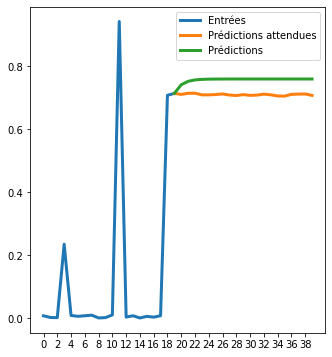

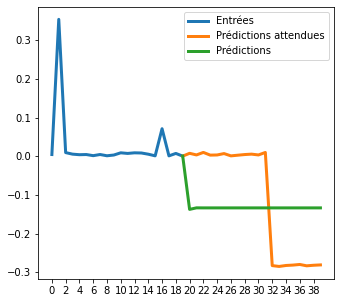

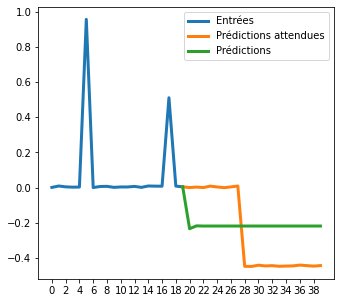

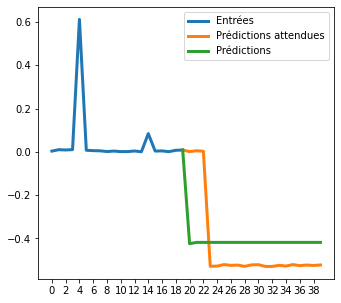

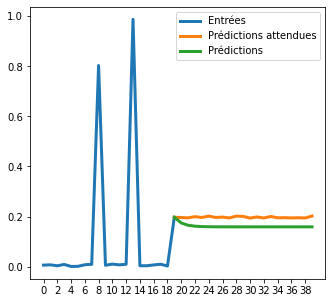

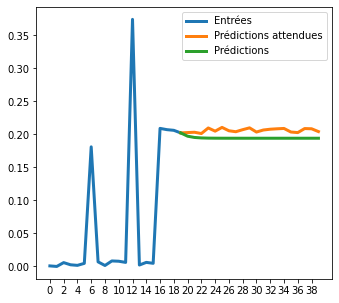

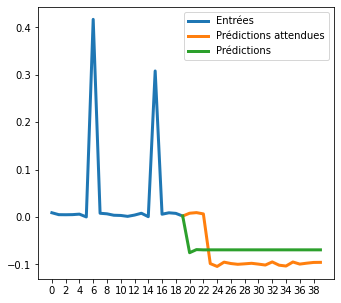

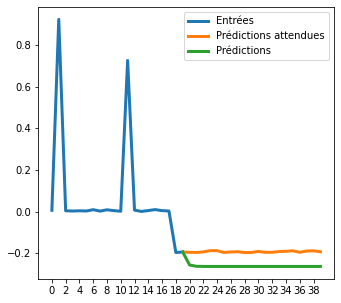

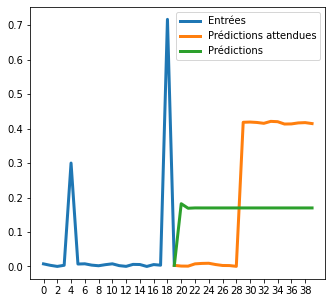

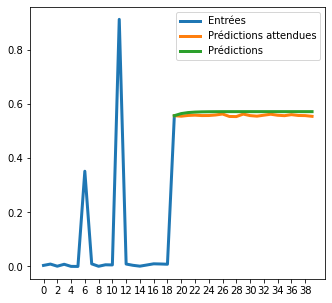

In [ ]:
iterateur_sur_chargement_test = iter(chargement_test)
test_entrees, test_prediction_attendue = next(iterateur_sur_chargement_test)

test_entrees = torch.tensor(test_entrees,dtype=torch.float32).to(processeur)
test_predictions_attendues = torch.tensor(test_prediction_attendue,dtype=torch.float32).to(processeur)

for index in range(0,10):
  plt.figure()
  plt.rcParams['figure.figsize']=(18.0,5.0)
  test_predictions = encodeur_decodeur(test_entrees).to(processeur)
  entrees = test_entrees.detach().cpu().numpy()[index,:,:]
  predictions_attendues = test_predictions_attendues.detach().cpu().numpy()[index,:,:]
  predictions = test_predictions.detach().cpu().numpy()[index,:,:]

  plt.subplot(1,3,1)
  plt.plot(range(0,longueur_partie_apprentissage_serie_temporelle),entrees,label="Entrées",linewidth=3)
  plt.plot(
      range(longueur_partie_apprentissage_serie_temporelle-1,longueur_partie_apprentissage_serie_temporelle+longueur_partie_a_predire_serie_temporelle),
      np.concatenate([entrees[longueur_partie_apprentissage_serie_temporelle-1:longueur_partie_apprentissage_serie_temporelle+longueur_partie_a_predire_serie_temporelle], predictions_attendues]),
      label="Prédictions attendues",linewidth=3
  )
  plt.plot(
      range(longueur_partie_apprentissage_serie_temporelle-1,longueur_partie_apprentissage_serie_temporelle+longueur_partie_a_predire_serie_temporelle),
      np.concatenate([entrees[longueur_partie_apprentissage_serie_temporelle-1:longueur_partie_apprentissage_serie_temporelle+longueur_partie_a_predire_serie_temporelle], predictions]),
      label="Prédictions",linewidth=3
  )
  plt.xticks(range(0,40,2))
  plt.legend()
  plt.show()
